In [76]:
import sys
import numpy as np
import time
from tqdm.notebook import tqdm as tqdm
# !{sys.executable} -m pip install tqdm

# Preliminaries 

## Delone Approximation Heuristics

In [235]:
# TODO раскопать историю разработки данной эвристики. Найти авторов из 80х, кто первый предложил её
# Надо решить, передаётся только список индексов или набор пар с расстояниями до curr.
# пока предполагаем, что в candidates передаётся только список индексов
# Return list of [: ]
def heuristic(candidates, curr, k, distance_func, data):
    candidates = sorted(candidates, key=lambda a: a[1])
    result_indx_set = {candidates[0][0]}
    result = [candidates[0]]
    added_data = [ data[candidates[0][0]] ]
    for c, curr_dist in candidates[1:]:
        c_data = merged_data[c]       
        if curr_dist < min(map(lambda a: distance_func(c_data, a), added_data)):
            result.append( (c, curr_dist))
            result_indx_set.add(c)
            added_data.append(c_data)
    
    # for c, curr_dist in candidates: # optional
    #     if len(result) < k and (c not in result_indx_set):
    #         result.append( (c, curr_dist) )   
    return result
def k_closest(candidates: list, curr, k, distance_func, data):
    return sorted(candidates, key=lambda a: a[1])[:k]

In [236]:
from heapq import heapify, heappop, heappush, heapreplace, nlargest, nsmallest

def l2_distance(a, b):
    return np.linalg.norm(a - b)

class DeloneApproximationGraph(object): 
    def __init__(self, k, dim, dist_func, neigborhood_construction, data):
        self.distance_func = dist_func
        self.k = k
        self.dim = dim
        self.count_brute_force_search = 0
        self.count_greedy_search = 0
        self.data = data
        # build k-graph by brute force knn-search
        print('Building k-graph')
        self.edges = []
        for x in tqdm(self.data):
            candidates = self.brute_force_knn_search(2*k+1, x)[1:]

            neighborhood = neigborhood_construction(candidates, x, k, dist_func, self.data)
            self.edges.append(neighborhood)
            
            
        self.reset_counters()

    def beam_search(self, q, k, eps, ef, ax=None, marker_size=20, observed=False):
        '''
        q - query
        k - number of closest neighbors to return
        eps – entry points [vertex_id, ..., vertex_id]
        ef – size of the beam
        observed – if True returns the full of elements for which the distance were calculated
        returns – a list of tuples [(vertex_id, distance), ... , ]
        '''
        # Priority queue: (negative distance, vertex_id)
        candidates = []
        visited = set()  # set of vertex used for extending the set of candidates
        observed = dict() # dict: vertex_id -> float – set of vertexes for which the distance were calculated

        if ax:
            ax.scatter(x=q[0], y=q[1], s=marker_size, color='red', marker='^')
            ax.annotate('query', (q[0], q[1]))

        # Initialize the queue with the entry points
        for ep in eps:
            dist = self.distance_func(q, self.data[ep])
            heappush(candidates, (dist, ep))
            observed[ep] = dist

        while candidates:
            # Get the closest vertex (furthest in the max-heap sense)
            dist, current_vertex = heappop(candidates)

            if ax:
                ax.scatter(x=self.data[current_vertex][0], y=self.data[current_vertex][1], s=marker_size, color='red')
                ax.annotate( len(visited), self.data[current_vertex] )

            # check stop conditions #####
            observed_sorted = sorted( observed.items(), key=lambda a: a[1] )
            # print(observed_sorted)
            ef_largets = observed_sorted[ min(len(observed)-1, ef-1 ) ]
            # print(ef_largets[0], '<->', -dist)
            if ef_largets[1] < dist:
                break
            #############################

            # Add current_vertex to visited set
            visited.add(current_vertex)

            # Check the neighbors of the current vertex
            for neighbor, _ in self.edges[current_vertex]:
                if neighbor not in observed:
                    dist = self.distance_func(q, self.data[neighbor])                    
                    # if neighbor not in visited:
                    heappush(candidates, (dist, neighbor))
                    observed[neighbor] = dist                    
                    if ax:
                        ax.scatter(x=self.data[neighbor][0], y=self.data[neighbor][1], s=marker_size, color='yellow')
                        # ax.annotate(len(visited), (self.data[neighbor][0], self.data[neighbor][1]))
                        ax.annotate(len(visited), self.data[neighbor])
                    
        
        # Sort the results by distance and return top-k
        observed_sorted =sorted( observed.items(), key=lambda a: a[1] )
        if observed:
            return observed_sorted
        return observed_sorted[:k]

    def reset_counters(self):
        self.count_brute_force_search = 0
        self.count_greedy_search = 0
    


    def _vectorized_distance(self, x, ys):
        return [self.distance_func(x, y) for y in ys]

    def brute_force_knn_search(self, k, x):
        '''
        Return the list of (idx, dist) for k-closest elements to {x} in {data}
        '''
        self.count_brute_force_search = self.count_brute_force_search + 1
        return sorted(enumerate(self._vectorized_distance(x, self.data)), key=lambda a: a[1])[:k]

    def plot_graph(self, ax, color, linewidth=0.5):        
        ax.scatter(self.data[:, 0], self.data[:, 1], c=color)
        for i in range(len(self.data)):
            for edge_end, dist in self.edges[i]:
                ax.plot( [self.data[i][0], self.data[edge_end][0]], [self.data[i][1], self.data[edge_end][1]], c=color, linewidth=linewidth )

## Data generation

In [237]:
dim = 2
n = 100
data_a = np.array(np.float32(np.random.random((n, dim))))
data_b = np.array(np.float32(np.random.random((n, dim))))

In [238]:
k = 7
kga_k = DeloneApproximationGraph(k=k, dim=dim, dist_func=l2_distance,  neigborhood_construction = k_closest, data=data_a)
kga_h = DeloneApproximationGraph(k=k, dim=dim, dist_func=l2_distance,  neigborhood_construction = heuristic, data=data_a)
# kgb = DeloneApproximationGraph(k=k, dim=dim, dist_func=l2_distance,  neigborhood_construction = k_closest, data=data_b)

Building k-graph


  0%|          | 0/100 [00:00<?, ?it/s]

Building k-graph


  0%|          | 0/100 [00:00<?, ?it/s]

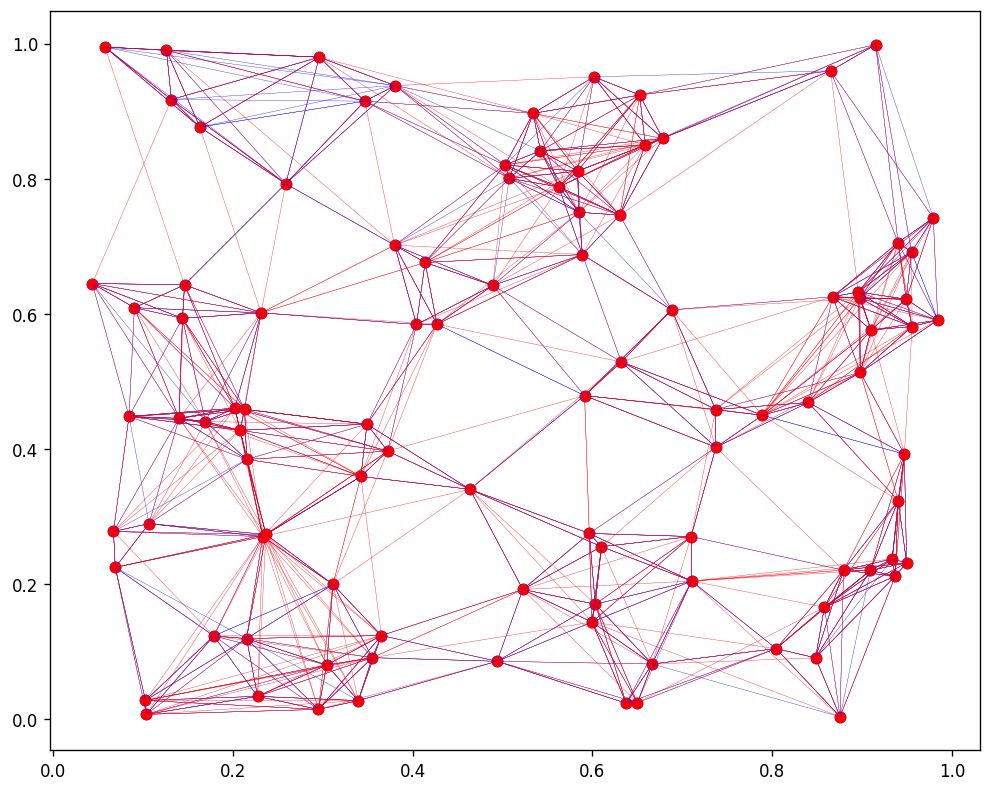

In [241]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120) 
kga_k.plot_graph(ax, color='blue', linewidth=0.2)
kga_h.plot_graph(ax, color='red', linewidth=0.2)

# kga.plot_graph(ax, color='blue', linewidth=0.2)
# kgb.plot_graph(ax, color='green', linewidth=0.2)
# candidates_2 = kgb.beam_search(q=kgb.data[6], k=5, eps=[0,50,100,150], ef=5, ax=ax, marker_size=30, )

## Estimate merging accuracy. Calc mergin ground truth 

In [240]:
gt_merged_edges = []
merged_data = np.concatenate((kga.data , kgb.data ), axis=0)
for i in tqdm(range(len(merged_data))):
    true_neighbors = sorted(enumerate(kga._vectorized_distance(merged_data[i], merged_data) ), key=lambda a: a[1])[1:k+1]
    true_neighbors = [idx for idx, dist in true_neighbors]
    gt_merged_edges.append(true_neighbors)
    
def merging_accuracy(merged_data, merged_edges)->float:
    recalls = []
    for curr in range(len(merged_data)):
        x = merged_data[curr]
        results = [idx for idx, dist in merged_edges[curr]]
        intersection = len(set(gt_merged_edges[curr]).intersection(set(results)))
        recall = intersection / k
        recalls.append(recall)
        
    return np.mean(recalls)

  0%|          | 0/200 [00:00<?, ?it/s]

# Now it is a time to merge 2 k-graphs

# Algorithm 0 – Naive
Seqensional traversing one graph by one with using regular beam_search <br> 
- Compexity $O(\log(N+M) \cdot (N + M) )$.
- Additional space on disk $O(N + M)$

In [154]:
import random
merged_edges = [ None for i in range(len(kga.data) + len(kgb.data) ) ]

currents = [] # sequence of steps for visualisation
observed_steps = [] # the of elements for which the distance were calculated on a particular step

def merge_naive(kga, kgb, search_ef=5, M = 5):
    '''
    kga          – first graph 
    kgb          – second graph
    search_ef    - ef parameter for searching candidates in the second grap
    M            – number of starting random enter points
                  
    '''

    enter_points = random.sample(range(len(kgb.data)), M)
    for curr_idx in range(len(kga.data)): 
        currents.append(curr_idx)
        observed = kgb.beam_search(kga.data[curr_idx], k, eps=enter_points, ef=search_ef, observed=True)
        observed_steps.append([ (idx+len(kga.data), dist) for idx, dist in observed])
        candidates_b = observed[:k]
        # == build neighborhood for curr_idx and save to externalset of edges  ==
        merged_edges[curr_idx] = sorted ([ (idx_b + len(kga.data), dist) for idx_b, dist in candidates_b] + [ (idx, dist) for idx, dist in kga.edges[curr_idx]], key=lambda a: a[1])[:k]
        # == == == == == == == == == == == == == == == == == == == == == == == ==

    enter_points = random.sample(range(len(kga.data)), M)
    for curr_idx in range(len(kgb.data)): 
        currents.append(curr_idx + len(kga.data))
        observed = kga.beam_search(kgb.data[curr_idx], k, eps=enter_points, ef=search_ef, observed=True)
        observed_steps.append([ (idx, dist) for idx, dist in observed])
        candidates_a = observed[:k]
        # == build neighborhood for curr_idx and save to externalset of edges  ==
        merged_edges[curr_idx + len(kga.data)] = sorted ([ (idx_a, dist) for idx_a, dist in candidates_a] + [ (idx + len(kga.data), dist) for idx, dist in kgb.edges[curr_idx]], key=lambda a: a[1])[:k]
        # == == == == == == == == == == == == == == == == == == == == == == == ==

merge_naive(kga, kgb, search_ef=20, M = 5)
print('Total metric calculation:', sum([len(steps) for steps in observed_steps ]))
print('Merging accuracy', merging_accuracy(merged_data, merged_edges))

Total metric calculation: 7643
Merging accuracy 0.9957142857142857


# Algorithm 1
Seqensional traversing one graph by one <br> 
- Version with no filter-beam-search
- Compexity O(N + M). Additional space on disk O(N + M)

In [155]:
import random
merged_edges = [ None for i in range(len(kga.data) + len(kgb.data) ) ]
merged_data = np.concatenate((kga.data , kgb.data ), axis=0)

currents = [] # sequence of steps for visualisation
observed_steps = [] # the of elements for which the distance were calculated on a particular step
jumps = []

def merge1(kga, kgb, inverse_flag, search_ef=5, next_step_k=1, next_step_ef=5, M = 5):
    '''
    kga          – first graph 
    kgb          – second graph
    inverse_flat – True if graphs are passed in inverse order
    search_ef    - ef parameter for searching candidates in the second graph
    next_step_k  - at each iteration we look for the next element around the current vertex in the first graph. 
                   However it can be surrounded by the "done" vertex, so we have to walk away. 
                   Thus this parameter controlls how far from the current vertex we can go.
    next_step_ef – a purpose of this parameter is similar {next_step_k}
    M            – number of starting random enter points
                  
    '''
    not_done = set( range(len(kga.data)) )
    shift = len(kga.data)
    reverse_shift = 0
    if inverse_flag:
        shift = 0
        reverse_shift = len(kgb.data)
        
    while not_done:
        curr_idx = not_done.pop()
        jumps.append(curr_idx)
    
        # enter_points = [0,50,100,150] # TODO select M random points of kgb
        enter_points = random.sample(range(len(kgb.data)), M)
        
        while True:
            currents.append(curr_idx + reverse_shift)
            observed = kgb.beam_search(kga.data[curr_idx], k, eps=enter_points, ef=search_ef, observed=True)
            # observed_steps.append(observed)
            observed_steps.append([ (idx+shift, dist) for idx, dist in observed])
            candidates_b = observed[:k]
            # == build neighborhood for curr_idx and save to externalset of edges  ==
            merged_edges[curr_idx + reverse_shift] = sorted ([ (idx_b + shift, dist) for idx_b, dist in candidates_b] + [ (idx + reverse_shift, dist) for idx, dist in kga.edges[curr_idx]], key=lambda a: a[1])[:k]
            # == == == == == == == == == == == == == == == == == == == == == == == ==
    
            enter_points = [idx for idx, dist in candidates_b] # ! determine a new set of enter_points for search on kgb
            
            candidates_a = kga.beam_search(kga.data[curr_idx], next_step_k, [ curr_idx], ef=next_step_ef, observed=True) # decrease k to traverse closer to curr vertex
            observed_steps[-1].extend([ (idx+reverse_shift, dist) for idx, dist in candidates_a])
            candidates_a = [c[0] for c in candidates_a[:next_step_k] if c[0] in not_done]
    
            if not candidates_a:
                break
            curr_idx = candidates_a[0]
            not_done.remove(curr_idx)

merge1(kga, kgb, inverse_flag=False, search_ef=20, next_step_k=5, next_step_ef=3, M = 5) # phase 1
merge1(kgb, kga, inverse_flag=True,  search_ef=20, next_step_k=5, next_step_ef=3, M = 5) # phase 2
print('Number of jumps:', len(jumps) ) 
print('Total metric calculation:', sum([len(steps) for steps in observed_steps ]))
print('Merging accuracy', merging_accuracy(merged_data, merged_edges))

Number of jumps: 30
Total metric calculation: 9130
Merging accuracy 0.9957142857142857


## Visualisation - Alg1

  0%|          | 0/1000 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.


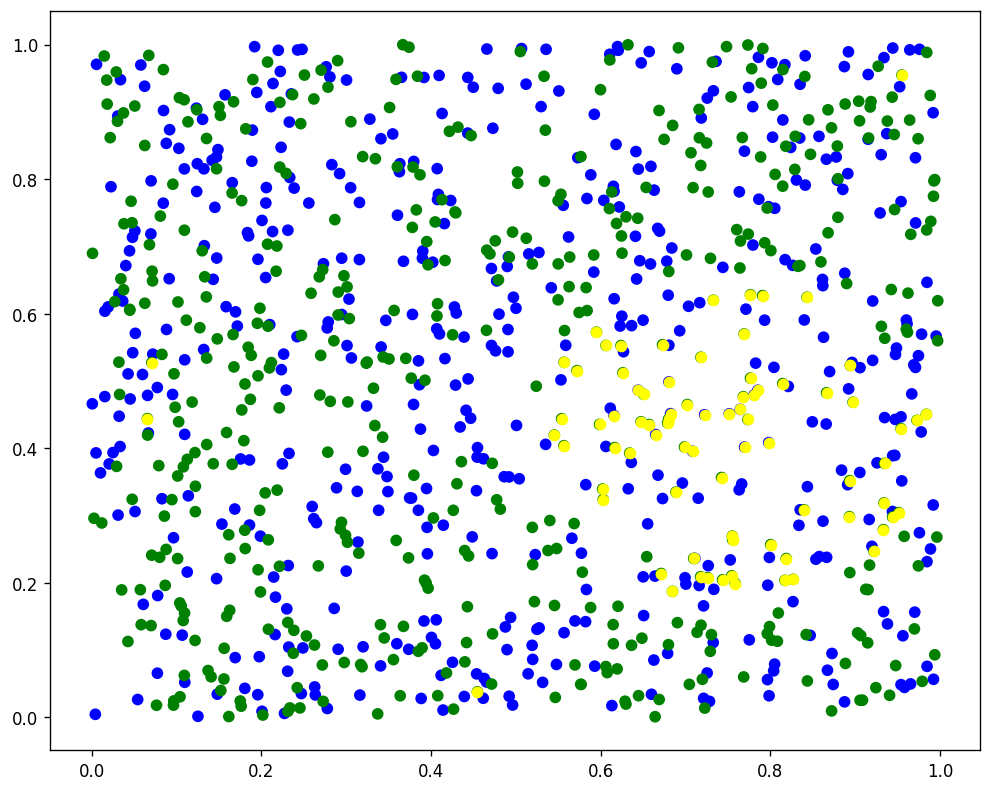

In [84]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)

# scat = ax.scatter(kga.data[:, 0], kga.data[:, 1], c='blue')
def update(frame):    
    ax.clear()
    # kga.plot_graph(ax, color='blue', linewidth=0.2)
    
    not_done = set(range(len(merged_data)))
    for i in range(frame):
        not_done.remove(currents[i])
    
    colors = ['blue' if i in not_done else 'black' for i in range(len(kga.data))]
    colors = colors + ['green' if i in not_done else 'black' for i in range(len(kga.data),len(merged_data))]
    
    # kga.plot_graph(ax, color='blue', linewidth=0.2)    
    ax.scatter(merged_data[:, 0], merged_data[:, 1], c=colors)

    for vertex_id, dist in observed_steps[frame]:
        ax.scatter(merged_data[vertex_id][0], merged_data[vertex_id][1], c='yellow')
    
    for i in range(frame):
        for edge_end, dist in merged_edges[currents[i]]:
            ax.plot( [merged_data[currents[i]][0], merged_data[edge_end][0]], [merged_data[currents[i]][1], merged_data[edge_end][1]], c= 'blue' if edge_end < len(kga.data) else 'green' )
        
    return fig, ax
ani = FuncAnimation(fig, update, frames=tqdm(range(len(merged_data))))
ani.save(f"gifs/merging-alg1-n-{n}.gif", fps=10)

![Algorithm1](gifs/merging-alg1-n100.gif "Merging Graphs - Algorithm 1")

# Algorithm 2
Traversing over two graphs<br>
- Version with no filter-beam-search
- Complexity $\theta (n+m)$ 

In [85]:
import random
merged_edges = [ None for i in range(len(kga.data) + len(kgb.data) ) ]
merged_data = np.concatenate((kga.data, kgb.data), axis=0)

currents = [] # sequence of steps for visualisation
observed_steps = [] # the of elements for which the distance were calculated on a particular step
jumps = []

def merge_alg2(kga, kgb, jump_ef = 20, search_ef=5, next_step_k=3, M = 3):
    '''
    kga          – first graph 
    kgb          – second graph
    search_ef    - ef parameter for searching candidates in the second graph
    next_step_k  - at each iteration we look for the next element around the current vertex in the first graph. 
                   However it can be surrounded by the "done" vertex, so we have to walk away. 
                   Thus this parameter controlls how far from the current vertex we can go.
    M            – number of starting random enter points                 
    '''
    not_done_a = set(range(len(kga.data)))
    not_done_b = set(range(len(kgb.data)))
    not_done = set(range(len(merged_data)))
    while not_done:
        curr_idx = random.choice(list(not_done))
        # not_done.remove(curr_idx) # remove from not_done
        jumps.append(curr_idx)
    
        enter_points_a = random.sample(range(len(kga.data)), M)
        enter_points_b = random.sample(range(len(kgb.data)), M)
        ef = jump_ef
        while True:
            currents.append(curr_idx)
            not_done.remove(curr_idx) # remove from not_done
            # print('curr_idx:', curr_idx)

            # searching for a new current
            observed_a = kga.beam_search(merged_data[curr_idx], k, eps=enter_points_a, ef=ef, observed=True)
            observed_b = kgb.beam_search(merged_data[curr_idx], k, eps=enter_points_b, ef=ef, observed=True)
            observed_steps.append(observed_a + [ (idx + len(kga.data), dist) for idx, dist in observed_b ])
            
            candidates_a = observed_a[:k]
            # print(candidates_a)
            candidates_b = observed_b[:k]

            # # == build neighborhood for new_curr_idx and save to externalset of edges  ==
            if curr_idx < len(kga.data):
                merged_edges[curr_idx] = sorted (kga.edges[curr_idx] + [ (idx_b + len(kga.data), dist) for idx_b, dist in candidates_b], key=lambda a: a[1])[:k]              
            else:
                merged_edges[curr_idx] = sorted (candidates_a + [(idx_b + len(kga.data), dist) for idx_b, dist in kgb.edges[curr_idx - len(kga.data)]], key=lambda a: a[1])[:k]
                  
            candidates_a_not_done = [ (idx, dist) for idx, dist in observed_a if idx in not_done]
            candidates_b_not_done = [ (idx + len(kga.data), dist) for idx, dist in observed_b if idx + len(kga.data) in not_done]
            
            candidates_not_done = [candidates_a_not_done[0]] if len(candidates_a_not_done) > 0 else [] + [candidates_b_not_done[0]] if len(candidates_b_not_done) > 0 else []

            if not candidates_not_done: 
                break #jump to the random point

            new_curr = min(candidates_not_done, key=lambda a: a[1])
            new_curr_idx = new_curr[0]
                        
            curr_idx = new_curr_idx
            enter_points_a = [idx for (idx, dist) in candidates_a]
            enter_points_b = [idx for idx, dist in candidates_b]
            ef = search_ef
                           
merge_alg2(kga, kgb, jump_ef=20, search_ef=10, next_step_k=5, M = 5)
print('Number of jumps:', len(jumps) ) 
print('Total metric calculation:', sum([len(steps) for steps in observed_steps ]))
print('Merging accuracy', merging_accuracy(merged_data, merged_edges))

Number of jumps: 15
Total metric calculation: 46469
Merging accuracy 0.9967142857142858


## Visualisation - ALG2

  0%|          | 0/1000 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.


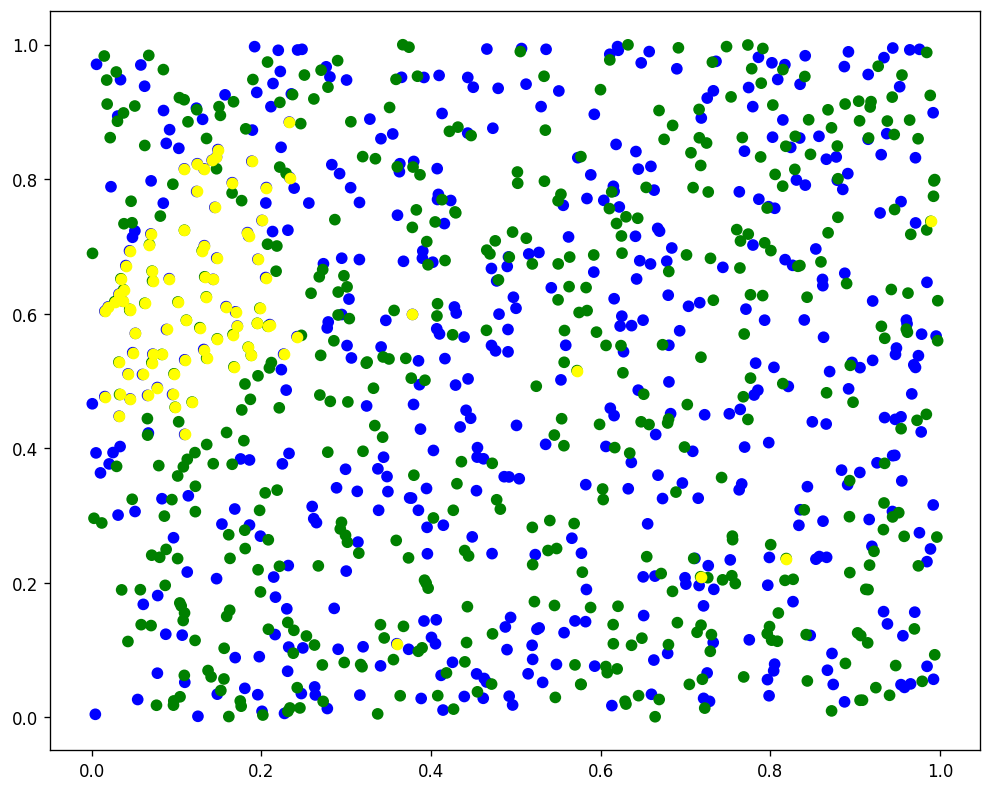

In [86]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)

# scat = ax.scatter(kga.data[:, 0], kga.data[:, 1], c='blue')
def update(frame):    
    ax.clear()
    # kga.plot_graph(ax, color='blue', linewidth=0.2)
    
    not_done = set(range(len(merged_data)))
    for i in range(frame):
        not_done.remove(currents[i])
    
    colors = ['blue' if i in not_done else 'black' for i in range(len(kga.data))]
    colors = colors + ['green' if i in not_done else 'black' for i in range(len(kga.data),len(merged_data))]
    
    for curr_idx in currents[:frame]:
        colors[curr_idx] = 'red' 
    
    # kga.plot_graph(ax, color='blue', linewidth=0.2)    
    ax.scatter(merged_data[:, 0], merged_data[:, 1], c=colors)

    for vertex_id, dist in observed_steps[frame]:
        ax.scatter(merged_data[vertex_id][0], merged_data[vertex_id][1], c='yellow')
    
    for i in range(frame):
        for edge_end, dist in merged_edges[currents[i]]:
            ax.plot( [merged_data[currents[i]][0], merged_data[edge_end][0]], [merged_data[currents[i]][1], merged_data[edge_end][1]], c= 'blue' if edge_end < len(kga.data) else 'green' )
        
    return fig, ax
ani = FuncAnimation(fig, update, frames=tqdm(range(len(merged_data))))
ani.save(f"gifs/merging-alg2-n-{n}.gif", fps=10)

In [672]:
import random
# merged_edges = [ None for i in range(len(kga.data) + len(kgb.data) ) ]
merged_edges = None
merged_data = None

merging_queue = []
queue_size = 10

currents = [] # sequence of steps for visualisation
observed_steps = [] # the of elements for which the distance were calculated on a particular step
jumps = []

def merge_alg3(kga, kgb, search_ef=5, next_step_k=3, M = 3):
    '''
    kga          – first graph 
    kgb          – second graph
    search_ef    - ef parameter for searching candidates in the second graph
    next_step_k  - at each iteration we look for the next element around the current vertex in the first graph. 
                   However it can be surrounded by the "done" vertex, so we have to walk away. 
                   Thus this parameter controlls how far from the current vertex we can go.
    M            – number of starting random enter points                 
    '''
    not_done_a = set(range(len(kga.data)))
    not_done_b = set(range(len(kgb.data)))
    not_done = set( range(len(kga.data) + len(kgb.data)) )   
    while not_done:
        curr_idx = random.choice(list(not_done))
        curr_data = kga.data[curr_idx] if curr_idx < len(kga.data) else kgb.data[curr_idx - len(kga.data)]
        jumps.append(curr_idx)
    
        enter_points_a = random.sample(range(len(kga.data)), M)
        enter_points_b = random.sample(range(len(kgb.data)), M)
        
        while True:
            currents.append(curr_idx)
            not_done.remove(curr_idx) # remove from not_done
            # print('curr_idx:', curr_idx)

            # searching for a new current
            observed_a = kga.beam_search(curr_data, k, eps=enter_points_a, ef=search_ef, observed=True)
            observed_b = kgb.beam_search(curr_data, k, eps=enter_points_b, ef=search_ef, observed=True)
            observed_steps.append(observed_a + [ (idx + len(kga.data), dist) for idx, dist in observed_b ])
            
            candidates_a = observed_a[:k]
            # print(candidates_a)
            candidates_b = observed_b[:k]


            # # == build neighborhood for new_curr_idx and save to externalset of edges  ==
            if curr_idx < len(kga.data):
                new_neighborhood = sorted (kga.edges[curr_idx] + [ (idx_b + len(kga.data), dist) for idx_b, dist in candidates_b], key=lambda a: a[1])[:k]
                merging_queue.append( (kga, curr_idx,  new_neighborhood) )
                # merged_edges[curr_idx] = sorted (kga.edges[curr_idx] + [ (idx_b + len(kga.data), dist) for idx_b, dist in candidates_b], key=lambda a: a[1])[:k]              
            else:
                new_neighborhood = sorted (candidates_a + [(idx_b + len(kga.data), dist) for idx_b, dist in kgb.edges[curr_idx - len(kga.data)]], key=lambda a: a[1])[:k]
                merging_queue.append( (kgb, curr_idx - len(kga.data),  new_neighborhood) )

            if len(merging_queue) >= queue_size:
                # do actual merging
                kgx, vertex_id, new_neighborhood = merging_queue.pop()
                kgx.edges[vertex_id] = new_neighborhood
                
                  
            candidates_a_not_done = [ (idx, dist) for idx, dist in observed_a if idx in not_done]
            candidates_b_not_done = [ (idx + len(kga.data), dist) for idx, dist in observed_b if idx + len(kga.data) in not_done]
            
            candidates_not_done = [candidates_a_not_done[0]] if len(candidates_a_not_done) > 0 else [] + [candidates_b_not_done[0]] if len(candidates_b_not_done) > 0 else []

            if not candidates_not_done: 
                break #jump to the random point

            new_curr = min(candidates_not_done, key=lambda a: a[1])
            new_curr_idx = new_curr[0]
                        
            curr_idx = new_curr_idx
            enter_points_a = [idx for (idx, dist) in candidates_a]
            enter_points_b = [idx for idx, dist in candidates_b]
            
    # update remaining neighborhoos
    for kgx, vertex_id, new_neighborhood  in merging_queue:
        kgx.edges[vertex_id] = new_neighborhood
                           
merge_alg3(kga, kgb, search_ef=3, next_step_k=3, M = 10)
print("Number of jumps:", len(jumps))
print('Total metric calculations:', sum([len(steps) for steps in observed_steps ]))

IndexError: index 294 is out of bounds for axis 0 with size 200